In [1]:
## imports
import pandas as pd
import numpy as np
import re
import requests
import yaml
import tweepy
import pickle
import plotnine
from plotnine import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

## function to load credentials yaml
def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

# Setup: authenticate to Twitter API

In [2]:
## read creds file
creds = load_creds("../private_data/my_cred.yaml")


In [36]:
## authenticate
### use oauth to authenticate with consumer key and secret
auth = tweepy.OAuthHandler(creds['twitter_api']['consumer_key'],
                          creds['twitter_api']['consumer_secret'])
### set access token
auth.set_access_token(creds['twitter_api']['access_token'],
                     creds['twitter_api']['access_token_secret'])
print(type(auth))

### initialize connection
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
print(type(api))

## check that our authentication worked
## source- https://realpython.com/twitter-bot-python-tweepy/
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")
    

<class 'tweepy.auth.OAuthHandler'>
<class 'tweepy.api.API'>


User(_api=<tweepy.api.API object at 0x7f7dd3ece910>, _json={'id': 42582848, 'id_str': '42582848', 'name': 'Rebecca Johnson', 'screen_name': 'beckyj1', 'location': 'Lebanon, NH', 'description': 'Assistant Professor @Dartmouth | Affiliate @TheLab_DC @OESatGSA | Former: @datascifellows @NIHbioethics\n\nEthics, data science, K-12 education, social policy.', 'url': 'https://t.co/aGsplq8nFB', 'entities': {'url': {'urls': [{'url': 'https://t.co/aGsplq8nFB', 'expanded_url': 'http://rebeccajohnson.io', 'display_url': 'rebeccajohnson.io', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 384, 'friends_count': 618, 'listed_count': 6, 'created_at': 'Tue May 26 07:20:43 +0000 2009', 'favourites_count': 506, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 105, 'lang': None, 'status': {'created_at': 'Fri May 07 20:54:00 +0000 2021', 'id': 1390771922925985799, 'id_str': '1390771922925985799', 'text': 'RT @young

Authentication OK


# Use one: pulling recent tweets associated with a hashtag

Here, we're going to pull recent tweets associated with the metoo hashtag. Note that if we want tweets older than a week, we need to either get an academic license (rather than a student one) or use another method (discussion here: https://stackoverflow.com/questions/24214189/how-can-i-get-tweets-older-than-a-week-using-tweepy-or-other-python-libraries) 

The `Cursor` class w/in tweepy allows us to pull while skipping annoying things like pagination

**Example use**: Gallagher et al. look at the use of hashtags #BlackLivesMatter, #AllLivesMatters, and others in days following instances of officer-involved shootings or indictments/non-indictments. They examine things like the different words that are used in tweets containing those hashtags and whether the conversations occur separately or whether those using the #AllLivesMatter hashtag are inserting themselves into BLM conversations: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195644

## Printing tweets and attributes of users

In [37]:
## construct a hashtag
## we're filtering out retweets for simplicity
## discussion here of filtering- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/
hashtag = "#metoo" + " -filter:retweets"
start_date = "2021-05-07"
end_date = "2021-05-11"

tweets = tweepy.Cursor(api.search, q = hashtag, lang = 'en', since = start_date,
                      until = end_date)


<class 'tweepy.cursor.Cursor'>


In [5]:
## more manually pull some attributes from tweets
## see here for a list of attributes of users: https://www.geeksforgeeks.org/python-user-object-in-tweepy/
n_examine = 10
tweets_subset = tweets.items(n_examine)
for one_tweet in tweets_subset:
    print("{user} from {loc} tweeted {tweet} on {date}".format(
        user = one_tweet.user.screen_name,
        loc = np.where(one_tweet.user.location == "",
                       "UNKNOWN", one_tweet.user.location),
        tweet = str(one_tweet.text),
        date = one_tweet.created_at))


Strange_G from New Zealand tweeted Oh Billy boy. How many #metoo are going to pop up now? https://t.co/emiYigggHX on 2021-05-10 23:58:31
Rising_Poiema from UNKNOWN tweeted This is the reality. #humantrafficking #churchtoo #metoo #religioustrauma https://t.co/RKb50eWM8A on 2021-05-10 23:54:56
Tom_Shone from New York tweeted Totally enjoying the new, sod-it candor of Winslet in MARE/AMMONITE — the first clear, quantifiable instance of… https://t.co/0DzsWdSfnM on 2021-05-10 23:53:54
Lorrain99345051 from Grande Prairie, Alberta tweeted And defended by our very own #TrudeauIncompetentPM #IncompetentCabinet #MeToo FAIL #ArmedForces https://t.co/oUSTAc6rmO on 2021-05-10 23:53:42
HydroMedic9375 from Connecticut, USA tweeted @AGooseStoic @rockerik01 @nowasforjason @acnewsitics And it's well documented that when he heard of his abuse towar… https://t.co/zuSGalsD9X on 2021-05-10 23:52:22
DaveLegacyuk from  Northamptonshire U.K. tweeted https://t.co/2xWXIJXv2T
#ThisMorning #Prayer #thoughts for #t

## Storing those in a dataframe

We also pull some other attributes of the users and of the tweets

In [6]:
## when running in notebook, set lower
## to reduce runtime
RUN_PULL = False
if RUN_PULL == True:
    max_rows = 100000
    tweets_list = [[one_tweet.user.screen_name,
                   one_tweet.user.location,
                   one_tweet.user.description,
                   one_tweet.user.followers_count,
                   one_tweet.user.geo_enabled,
                   one_tweet.text,
                   one_tweet.created_at,
                   one_tweet.favorite_count] for one_tweet in tweets.items(max_rows)]
    
    with open('../public_data/tweets_list.pkl', 'wb') as f:
        pickle.dump(tweets_list, f)
else:
    with open('../public_data/tweets_list.pkl', 'rb') as pickle_file:
        tweets_list = pickle.load(pickle_file)


In [7]:
## transform list into a dataframe
tweets_df = pd.DataFrame(tweets_list,
                        columns = ['sn', 'loc', 'desc', 'followers',
                                  'is_geo', 'tweet',
                                  'created',
                                  'likes'])

## look at ones with most and fewest likes
tweets_df.sort_values(by = "likes", ascending = False).head()

tweets_df.sort_values(by = "likes", ascending = False).tail()


,sn,loc,desc,followers,is_geo,tweet,created,likes
1703,bette_oh,,"Death by 2 viral tweets, but I’m back, Jack.",10584,False,"And, just like that, the #MeToo movement is gone. They dismantled as soon as Democrats were accused.",2021-05-05 16:21:12,1138
179,Chantel_Bx0,"Ontario, Canada",I have zero patience,2288,True,Who in the hell actually believes @JustinTrudeau didn’t know about the sexual harassment allegations in the military? #MeToo,2021-05-07 18:32:23,703
1928,helenlewis,helenlewis.substack.com,"Staff writer, @theAtlantic; author, Difficult Women: A History of Feminism in 11 Fights; presenter, BBC Radio 4's The Spark. Contact me via https://t.co/QP5QIs4ddM",139027,False,How two feminist flashpoints - #MeToo and the gender wars - have presented the biggest challenge yet to Scotland's… https://t.co/RmEF3l8nqw,2021-05-05 08:08:34,291
214,IshatReza,Canada,"🇨🇦 Lawyer & Workplace Investigator | @WorkplaceLP Host of Law@Work Podcast (link below) | Harvard, McGill, UofT alum | Photos https://t.co/MLmlpsdxTY",14348,False,1) PMJT’s Chief of Staff Katie Telford (@telfordk) is testifying before the HoC Standing Committee on National Defe… https://t.co/GajrO0l3fo,2021-05-07 17:28:06,290
513,FemCondition,,*Editor* Feminist not misandrist. Using my voice to raise awareness of male DV victims.,2886,False,"I believe that if a man/woman is to be fired, labeled and criminalized as an abuser- the evidence should meet crimi… https://t.co/WLTkOUnN02",2021-05-07 10:04:56,276


,sn,loc,desc,followers,is_geo,tweet,created,likes
961,mdlachner,"Durango, CO",,4,False,"Senator @SenatorHick, will you stand with military sexual assault survivors to pass the Military Justice Improvemen… https://t.co/nA6yzxuoyJ",2021-05-06 16:49:36,0
960,NoranneLenox,USA,"Outlaw#24, Always a Jock, PROUD AMERICAN! JUSTICE FOR ALL! 🥳🇺🇸❤",65,True,@PamelaMorley14 @LindseyBoylan Ummm ... THREATS AGAINST WOMEN ... SEVERAL WOMEN? I THOUGHT that wasn't allowed on T… https://t.co/LfArWlmmrI,2021-05-06 16:50:05,0
958,urrlynotalone,,Disabled DV victim. My story is not what you’ve heard before.... ask for my gofundme PLEASE.,3,False,I cannot understand the lack of resources for victims during covid. No pandemic should be an excuse to neglect our… https://t.co/fAhbrdvWd6,2021-05-06 16:55:46,0
955,4themilitary,"Washington, DC. 20004",New legislation allows active military to file a claim with the Dept. of Defense for military medical malpractice. Call us for a FREE consultation. We can help!,60,False,The family of Vanessa continues to fight for change within the military! They ask Congress to pass the “I Am Vaness… https://t.co/tb8e91WRaP,2021-05-06 17:09:05,0
1067,Karlyle_Tomms,Currently in Texas,#AwardWinning #Author & #Artist for a better world. #Books: https://t.co/yeXjlx9ZMO,9345,True,"Where are the boundaries, the actual boundaries? When do we determine, enough is enough? https://t.co/4l12JWw1tb… https://t.co/bRjAi9jNAX",2021-05-06 13:29:11,0


False    0.659736
True     0.340264
Name: is_geo, dtype: float64

/opt/conda/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


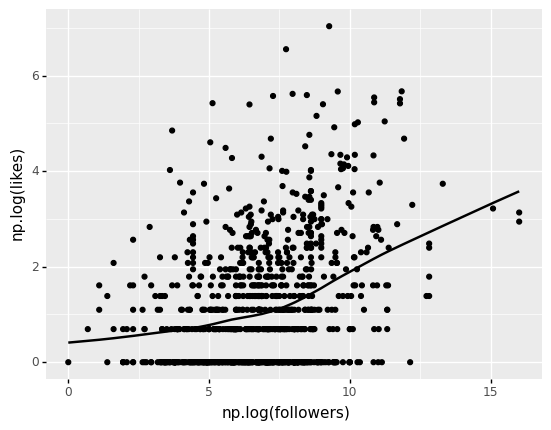

<ggplot: (8761159056348)>

@ProtectRDfnders    38
@YouTube            21
@TaranaBurke        17
@lucyloveWHAT       13
@rosemcgowan        12
                    ..
@SupremeCourt_TX     1
@erin_bsn            1
@RonniLaurie         1
@vampgirlI           1
@utkarsh_aanand      1
Length: 664, dtype: int64

In [8]:
## some exploration

### 1. what percent are geocoded?
tweets_df.is_geo.value_counts(normalize = True)

### 2. what's the relationship b/t followers and likes? (logged and removing 0)
(ggplot(tweets_df[(tweets_df.followers > 0) &
                  (tweets_df.likes > 0)], 
                  aes(x = 'np.log(followers)', y = 'np.log(likes)')) +
geom_point() +
geom_smooth())

## 3. who was tagged?
### define pattern
tag_pat = r".*(@\w+).*"
### iterate over tweets
all_tags = [re.findall(tag_pat, one_tweet) 
            for one_tweet in tweets_df.tweet
           if len(re.findall(tag_pat, one_tweet)) > 0]
### flatten list to count repeats and summarize top
all_tags_onelist = [item for sublist in all_tags for item in sublist]
pd.Series(all_tags_onelist).value_counts()


In [9]:
## print tweets w/ that military SA account tagged
## see that high count is the advocacy org
## tagging senators and also tagging themselves
print(tweets_df.tweet[tweets_df.tweet.str.contains("ProtectRDfnders")].head())

167    @EarlyFaye2 @NotInMyMarines @ProtectRDfnders @Neveraloneadvo1 @SenGillibrand @SenJoniErnst This most likely based o… https://t.co/6KCVUZ2J3j
803    .@SenJohnBarrasso will you support the @ProtectRDfnders Senate pledge to make sure military survivors of sexual ass… https://t.co/wk1fDj7L14
804    .@SenRonJohnson will you support the @ProtectRDfnders Senate pledge to make sure military survivors of sexual assau… https://t.co/QU0STWlkmd
805    .@Sen_JoeManchin will you support the @ProtectRDfnders Senate pledge to make sure military survivors of sexual assa… https://t.co/r52a1GMihi
807    .@SenatorRomney will you support the @ProtectRDfnders Senate pledge to make sure military survivors of sexual assau… https://t.co/Dl7JcW3pmm
Name: tweet, dtype: object


# Use two: examining relationships between those on the site

- Previous example showed both who tweeted with a lot of likes/high follower counts, and also who they tended to tag in the tweets
- We can also use twitter to form the start of a social network where nodes are different accounts and edges are drawn between followers who follow the same focal account; here, we'll look at a simplified form

**Example use**: Mosleh et al. do a field experiment where they create Twitter bots that either self-identify as Republican or Democrat and then the bots follow people. They look at how the partisanship of the user the bot follows predicts whether the user follows a bot back: https://www.pnas.org/content/118/7/e2022761118.short

In [12]:
## pull 50 most recent followers of one user
max_follow = 50
PULL_FOLLOW = False
focal_account = "ProtectRDfnders"
if PULL_FOLLOW:
    followers_list = [follower.screen_name for follower in tweepy.Cursor(api.followers, 
                                    focal_account).items(max_follow)]
    with open('../public_data/followers_list.pkl', 'wb') as f:
        pickle.dump(followers_list, f)
else:
    with open('../public_data/followers_list.pkl', 'rb') as f:
        followers_list = pickle.load(f)

In [26]:
## focusing on a couple followers and their 100
## most recent follows for runtime management
focal_follower1 = 'ArmyofNaveed'
focal_follower2 = 'WithoutViolence'

PULL_WHOTHEYFOLLOW = False
if PULL_WHOTHEYFOLLOW:
    followers_focal1 = [follow.screen_name for follow in
                    tweepy.Cursor(api.friends, screen_name = focal_follower1).items(100)]
    with open("../public_data/followers_focal1.pkl", 'wb') as f:
        pickle.dump(followers_focal1, f)
    followers_focal2 = [follow.screen_name for follow in
                    tweepy.Cursor(api.friends, screen_name = focal_follower2).items(100)]
    with open("../public_data/followers_focal2.pkl", 'wb') as f:
        pickle.dump(followers_focal2, f)
else:
    with open("../public_data/followers_focal1.pkl", 'rb') as f:
        followers_focal1 = pickle.load(f)
    with open("../public_data/followers_focal2.pkl", 'rb') as f:
        followers_focal2 = pickle.load(f)



In [34]:
overlap_followers = set(followers_focal1).intersection(followers_focal2)
overlap_followers

## seems like only the military SA account (at least among recent!
## but might get diff results with a larger pull)

{'ProtectRDfnders'}

# Use three: extract recent tweets from a specific user

If we have a dataset or panel of users, can get their tweets and extract properties like likes, retweets, etc; limited to ~3000 most recent (see documentation)

**Example use**: Bisbee et al. construct a panel of political science professors use Twitter; they then follow those users and looks at who retweets each other's research, finding that male professors are more likely to pass on research by other male professors than by female professors - https://www.cambridge.org/core/journals/perspectives-on-politics/article/polisci-twitter-a-descriptive-analysis-of-how-political-scientists-use-twitter-in-2019/C8A193C3E939C1ABCD4600DFE8AEF79A

In [68]:
focal_account = "SenatorHassan"
max_items = 100
senator_tweets = [[tweet.id, tweet.id_str,
                tweet.text, tweet.created_at, tweet.retweet_count, tweet.favorite_count] for
                 tweet in tweepy.Cursor(api.user_timeline, focal_account).items(100)]

senator_tweets_df = pd.DataFrame(senator_tweets,
                                columns = ['tweet_id', 'tweet_id_str',
                                           'tweet', 'created',
                                          'retweets', 'likes'])
senator_tweets_df.sort_values(by = 'retweets', ascending = False)

,tweet_id,tweet_id_str,tweet,created,retweets,likes
20,1391518471159156738,1391518471159156738,RT if you believe workers deserve paid leave to take care of their sick children or elderly parents.,2021-05-09 22:20:31,841,1602
58,1388584162211282945,1388584162211282945,Broadband is infrastructure. And we need to make sure that every community across the country has access to it.,2021-05-01 20:00:37,204,898
38,1389939889152708614,1389939889152708614,"Without caregivers to help with everyday tasks — grocery shopping, getting dressed — more than 3.5 million American… https://t.co/48FLQf3I19",2021-05-05 13:47:48,193,697
15,1392127667294593032,1392127667294593032,Today the Senate is marking up the #ForThePeople Act. That means we’re about to get one step closer to stopping cor… https://t.co/28dt0QxEcO,2021-05-11 14:41:15,188,779
65,1387844748690534401,1387844748690534401,We just passed the Drinking Water and Wastewater Infrastructure Act on an overwhelmingly bipartisan basis. That mea… https://t.co/f0ImSsM2X1,2021-04-29 19:02:27,184,1103
...,...,...,...,...,...,...
4,1392596122821177348,1392596122821177348,"Today the subcommittee I lead discussed the @USGAO's 2021 report on duplication, overlap, and fragmentation.\n\nIn sh… https://t.co/kxr7sqVQSR",2021-05-12 21:42:43,6,18
26,1390714041476292615,1390714041476292615,"The STANDUP Act would require states, public schools, and Tribes to implement evidence-based policies and trainings… https://t.co/QUTbL4EIOb",2021-05-07 17:04:00,5,16
39,1389743402024112130,1389743402024112130,RT @nhpr: Updated post: A bill supported by @SenatorHassan and @SenatorShaheen would expand coverage of telehealth services through Medicar…,2021-05-05 00:47:01,5,0
95,1386796561678716933,1386796561678716933,Flying the POW/MIA flag is one way in which we honor the extraordinary sacrifices of service members taken as priso… https://t.co/p0cIBH7iqx,2021-04-26 21:37:20,5,17


,tweet_id,tweet_id_str,tweet,created,retweets,likes,compound_sent
21,1391478074152259585,1391478074152259585,Get vaccinated so you can hug the people you love — Happy Mother’s Day! https://t.co/4p1zYcGd8T,2021-05-09 19:39:59,49,343,0.9110
22,1391407798148345858,1391407798148345858,"Being the mother of two wonderful children is a pure and unparalleled joy. So is being raised by my own smart, comp… https://t.co/E5XghXI3pW",2021-05-09 15:00:44,7,87,0.8807
79,1387525717739642880,1387525717739642880,I'm on board! Proud to cosponsor the SHIPYARD Act to help support our national security and economy by investing in… https://t.co/Pzvh4a0HSR,2021-04-28 21:54:44,11,24,0.8805
8,1392508599289659405,1392508599289659405,This is fantastic — *one million* Americans have enrolled in a health care plan during this Affordable Care Act spe… https://t.co/UiZIpjQOlQ,2021-05-12 15:54:56,10,34,0.8750
14,1392142012493799427,1392142012493799427,This is great news — authorizing the Pfizer vaccine for children ages 12 to 15 will help protect more American fami… https://t.co/rUQ9Bczbuc,2021-05-11 15:38:15,8,28,0.8555
...,...,...,...,...,...,...,...
87,1387179648707141632,1387179648707141632,"It can be hard to find doctors that specialize in substance use disorder treatment, especially in rural areas. That… https://t.co/Qf579OjfXk",2021-04-27 22:59:35,9,36,-0.4767
9,1392292746187186177,1392292746187186177,"I condemn Hamas’ attacks on Israeli citizens — they must stop, and Israel has a right to defend itself. I urge de-e… https://t.co/NnFcKFg43n",2021-05-12 01:37:12,58,301,-0.7717
13,1392158631269998595,1392158631269998595,"The substance use disorder crisis has devastated families across our state, leaving many grandparents raising their… https://t.co/OquKI0Kld6",2021-05-11 16:44:17,8,19,-0.8957
18,1391813900946100229,1391813900946100229,There's no other way to say it: gun violence is a public health crisis. \nhttps://t.co/nBfGB0bs2x,2021-05-10 17:54:27,44,129,-0.9153


/opt/conda/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


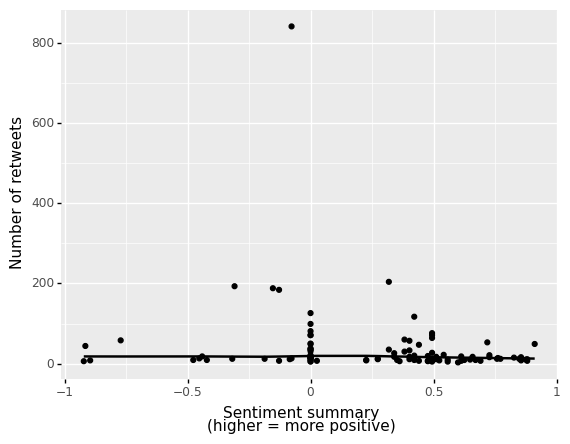

<ggplot: (8761150204992)>

/opt/conda/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


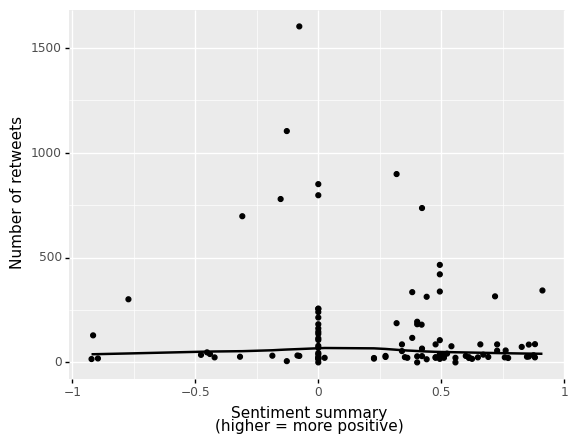

<ggplot: (8761149822196)>

In [69]:
## do sentiment scoring on the tweet
si_scorer = SentimentIntensityAnalyzer()
senator_tweets_df['compound_sent'] = [si_scorer.polarity_scores(one_tweet)['compound'] 
                                      for one_tweet in senator_tweets_df.tweet]
senator_tweets_df.sort_values(by = 'compound_sent', ascending = False)

## no clear relationship
(ggplot(senator_tweets_df, aes(x = 'compound_sent', y = 'retweets')) +
geom_point() +
xlab("Sentiment summary\n(higher = more positive)") +
ylab("Number of retweets") +
geom_smooth())

(ggplot(senator_tweets_df, aes(x = 'compound_sent', y = 'likes')) +
geom_point() +
xlab("Sentiment summary\n(higher = more positive)") +
ylab("Number of retweets") +
geom_smooth())

# Activity

- Choose a public user (e.g., a politician; celebrity) and pull the 20 most recent tweets on their timeline and metadata about those tweets (e.g., created time; favorites; retweets)
- Choose one of the tweets to focus on that got a lot of engagement and use the below example code w/ one of Hassan's tweets (adapted from here: https://stellamindemography.wordpress.com/2018/05/04/mining-data-from-twitter-and-replies-to-tweets-with-tweepy/) to pull some replies
- Use text analysis to characterize themes in the replies -- eg you could do sentiment analysis or look at top words

In [73]:

## practice getting replies

replies=[] 
tweet_id_str = '1391518471159156738'
for tweet in tweepy.Cursor(api.search,q='to:SenatorHassan', since_id=tweet_id_str, 
                result_type='recent',timeout=999999).items(1000):
    if hasattr(tweet, 'in_reply_to_status_id_str'):
        if (tweet.in_reply_to_status_id_str==tweet_id_str):
            replies.append(tweet.text)


In [74]:
replies

['@SenatorHassan And how are you losers in DC going to administer this?  You must be totally clueless to think giving… https://t.co/urAoa8wwlb',
 '@SenatorHassan Seems like gov paying for care would be better policy approach. Can include paying family members to care for each other.',
 '@SenatorHassan #MSC2000 Monthly Stimulus ✔️ s $2000 thru Pandemic plus 6 more months for ALL Adults plus Adult Depe… https://t.co/IWp2Rztn7U',
 '@SenatorHassan But the people have to suffer that didn’t get Fpuc from August till January last year?We are in extr… https://t.co/Fse6lhpeA1',
 '@SenatorHassan Yes we do!',
 "@SenatorHassan Mother's day yesterday. It made us think of all the mothers fighting to save their Diversity Visa cr… https://t.co/Z7wieklgSc",
 '@SenatorHassan @SenTinaSmith ...or spouse!',
 '@SenatorHassan @ProudAm55793141 Its Either Someone in the Family Takes Care of The Elderly, Or a Nursing Home\nDoes..?',
 '@SenatorHassan @jocowboys87 Ummm disabled',
 '@SenatorHassan Who is going to 